In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.cm as cm
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec

from src.cdr_bench.io_utils.io import read_optimization_results
from src.cdr_bench.scoring.scoring import calculate_distance_matrix, count_neighbors_with_high_similarity, indices_of_neighbors_with_high_similarity
from src.cdr_bench.visualization.visualization import create_hexbin_plot

from sklearn.preprocessing import StandardScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def calculate_overlap(matrix1, matrix2, k):
    overlaps = []
    for i in range(matrix1.shape[0]):
        nearest_neighbors1 = np.argsort(matrix1[i], kind='stable')[:k+1]
        nearest_neighbors2 = np.argsort(matrix2[i], kind='stable')[:k+1]
        overlap_count = (len(set(nearest_neighbors1).intersection(set(nearest_neighbors2))) - 1) / k# * 100
        overlaps.append(overlap_count)
    return overlaps

In [14]:
def process_data(file_path, descriptor_set, methods_to_extract):
    df, fp_array, results = read_optimization_results(file_path, feature_name=descriptor_set, method_names=methods_to_extract)
    
    # Filter out constant columns
    non_constant_columns = np.any(fp_array != fp_array[0, :], axis=0)
    fp_array = fp_array[:, non_constant_columns]

    # Calculate ambient distance matrix
    ambient_dist = calculate_distance_matrix(fp_array.astype(np.float64), metric='tanimoto')

    # Calculate overlaps for each method
    k = 20
    for method in methods_to_extract:
        latent_dist = calculate_distance_matrix(np.vstack(results[method]['coordinates'].tolist()).astype(np.float64), metric='euclidean')
        df[f'{method}'] = calculate_overlap(ambient_dist, latent_dist, k)
    
    return df, results

# Read the data

In [15]:
# File paths and settings
file_paths = ['../results/in_sample_eucl/CHEMBL3638344/mfp_r2_1024/mfp_r2_1024.h5',
              '../results/in_sample_eucl/fid_6/mfp_r2_1024/mfp_r2_1024.h5'] 
descriptor_set = 'mfp_r2_1024'
methods_to_extract = ['PCA', 't-SNE', 'UMAP', 'GTM']

# Process both datasets
dfs_results = [process_data(file_path, descriptor_set, methods_to_extract) for file_path in file_paths]

# Plot heatmaps

/tmp/ipykernel_1178268/1847199386.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


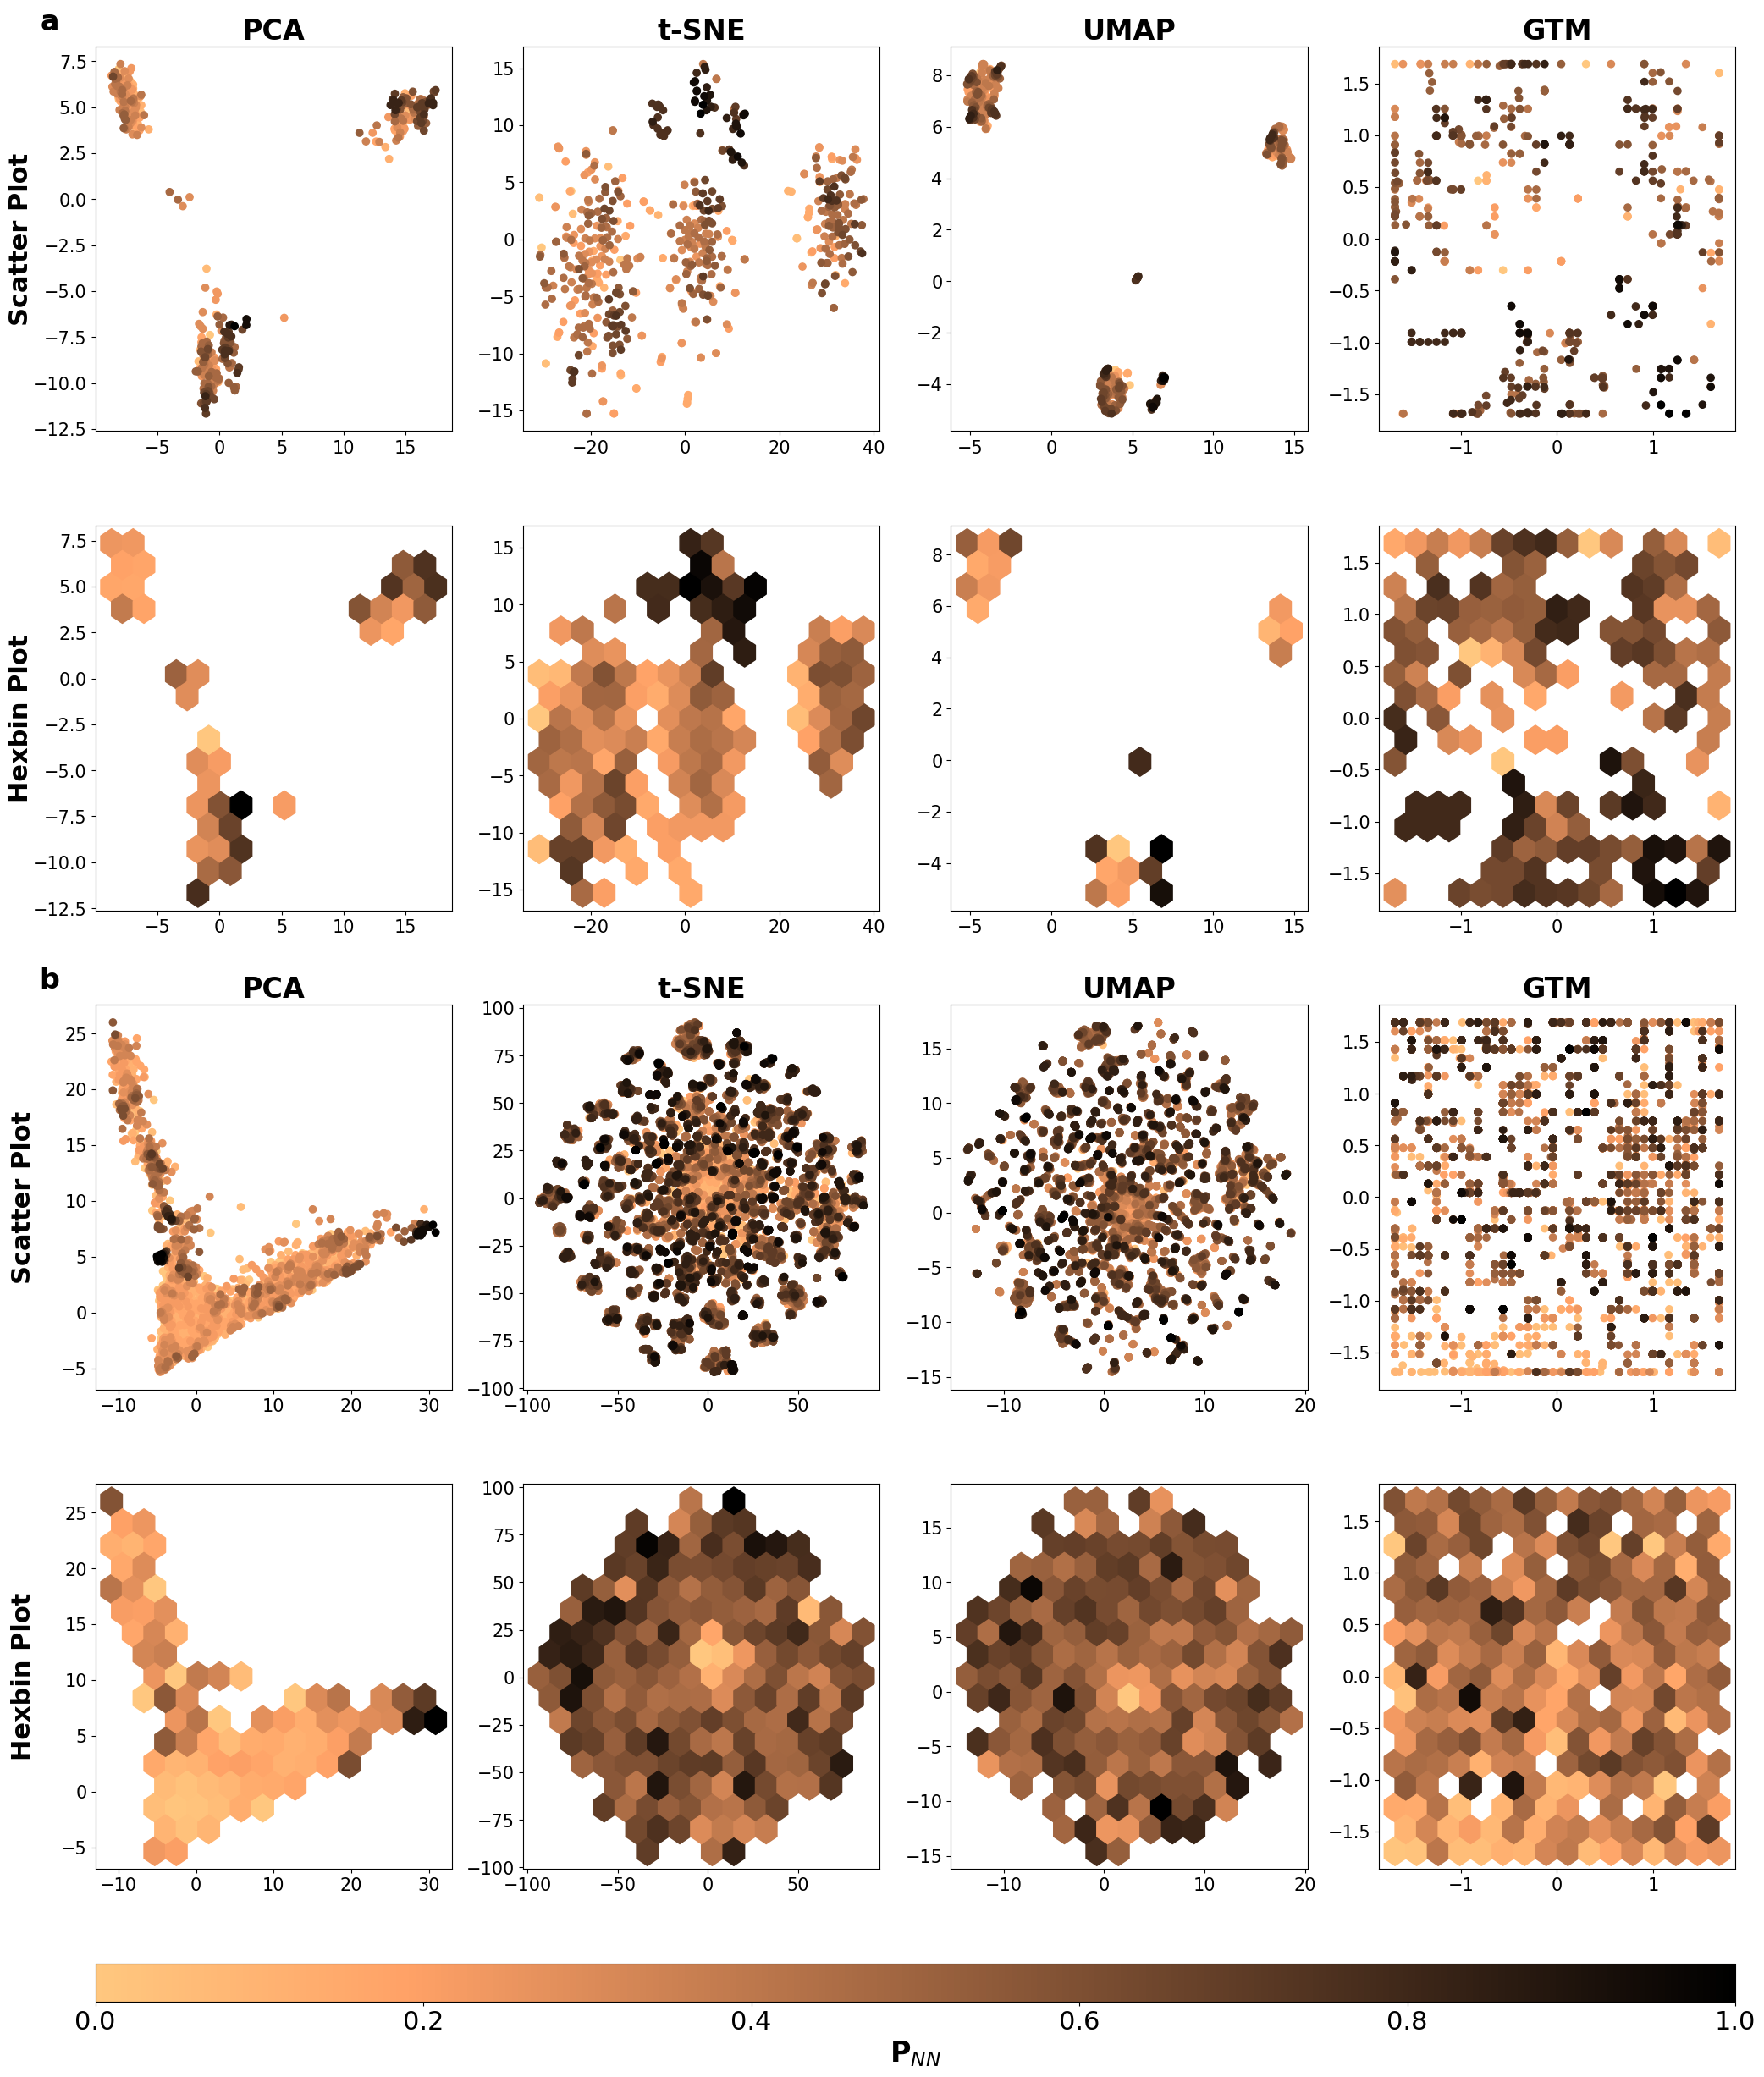

In [16]:
# Plotting
fig = plt.figure(figsize=(25, 30))
gs = GridSpec(5, 4, height_ratios=[1, 1, 1, 1, 0.1], hspace=0.3, wspace=0.2)

methods = ['PCA', 't-SNE', 'UMAP', 'GTM']
axs = []

for i, method in enumerate(methods):
    for j, (df, results) in enumerate(dfs_results):
        #coords = results[method]['coordinates']
        df[f'{method}_coords'] = list(results[method]['coordinates'])
        df = df.sort_values(f'{method}')
        coords = np.vstack(df[f'{method}_coords'].tolist())
        # Scatter plots
        if j == 1:
            j+=1
        ax = fig.add_subplot(gs[j, i])
        sc = ax.scatter(coords[:, 0], coords[:, 1], c=df[f'{method}'].tolist(), cmap='copper_r')
        ax.tick_params(axis='both', which='major', labelsize=15)
        if i == 0 and j==0:  # Add label to the left of the first column of plots
            ax.set_ylabel(f'Scatter Plot', fontsize=22, fontweight='bold', labelpad=0)
        if i == 0 and j==2:  # Add label to the left of the first column of plots
            ax.set_ylabel(f'Scatter Plot', fontsize=22, fontweight='bold', labelpad=22)
        if j == 0 or j == 2:
            ax.set_title(f'{method}', fontsize=24, fontweight='bold')
        # Add label 'a' and 'b' to the top left of first and third rows, respectively
        if j == 0 and i == 0:
            ax.text(-0.1, 1.1, 'a', transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')
        if j == 2 and i == 0:
            ax.text(-0.1, 1.1, 'b', transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')
        axs.append(ax)
        
        # Hexbin plots
        ax = fig.add_subplot(gs[j+1, i])
        hb = ax.hexbin(coords[:, 0], coords[:, 1], C=df[f'{method}'].tolist(), gridsize=15, cmap='copper_r')
        ax.tick_params(axis='both', which='major', labelsize=15)
        if i == 0 and j == 0:  # Add label to the left of the first column of plots
            #ax.set_title(f'{method}', fontsize=20)
            ax.set_ylabel(f'Hexbin Plot', fontsize=22, fontweight='bold', labelpad=0)
        if i == 0 and j == 2:  # Add label to the left of the first column of plots
            #ax.set_title(f'{method}', fontsize=20)
            ax.set_ylabel(f'Hexbin Plot', fontsize=22, fontweight='bold', labelpad=22)
        axs.append(ax)
        
# Add a single colorbar below the second row
cax = fig.add_subplot(gs[-1, :])
cbar = fig.colorbar(hb, cax=cax, orientation='horizontal')
# Set the color limits for the colorbar

cbar.ax.tick_params(labelsize=22)
cbar.set_label(r"P$_{NN}$", fontsize=24, fontweight='bold')  # Set the colorbar title
hb.set_clim(0.0, 1.0)
# Adjust layout
plt.tight_layout()
plt.show()